In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from constants import SAMPLES
from constants import matching_cores_2024 as matching_cores
from st_utils import name_parser, correct_platform_panel

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

wd = os.getcwd()
print (f'working directory: {wd}')


year = '2024'

if year == '2024':
    samples = [
    '2024_xenium_breast_htma',
    '2024_cosmx_multitissue_htma',
    '2024_merscope_breast_htma',
    ]
elif year == '2023':
    samples = [
    'xenium_breast_htma',
    'cosmx_multitissue_htma',
    'merscope_breast_htma',
    ]

print (samples)

/Users/whuan/opt/anaconda3/envs/sp/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


working directory: /Users/whuan/dev/ist_benchmarking
['2024_xenium_breast_htma', '2024_cosmx_multitissue_htma', '2024_merscope_breast_htma']


In [3]:
! gsutil cp gs://fc-b8e703d3-de2d-4532-94cc-efe864b4feea/SPARC/processed_data/data/2024_xenium_breast_tumor2/morphology_focus_0000_reoriented.tif data/2024_xenium_breast_tumor2/



Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

Copying gs://fc-b8e703d3-de2d-4532-94cc-efe864b4feea/SPARC/processed_data/data/2024_xenium_breast_tumor2/morphology_focus_0000_reoriented.tif...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

- [1 files][  6.2 GiB/  6.2 GiB]   14.0 MiB/s                                   
Operation completed over 1 objects/6.2 GiB.                                      


# Co-expression plot

CD3E EPCAM
2024_xenium_breast_htma
2024_cosmx_multitissue_htma
2024_merscope_breast_htma


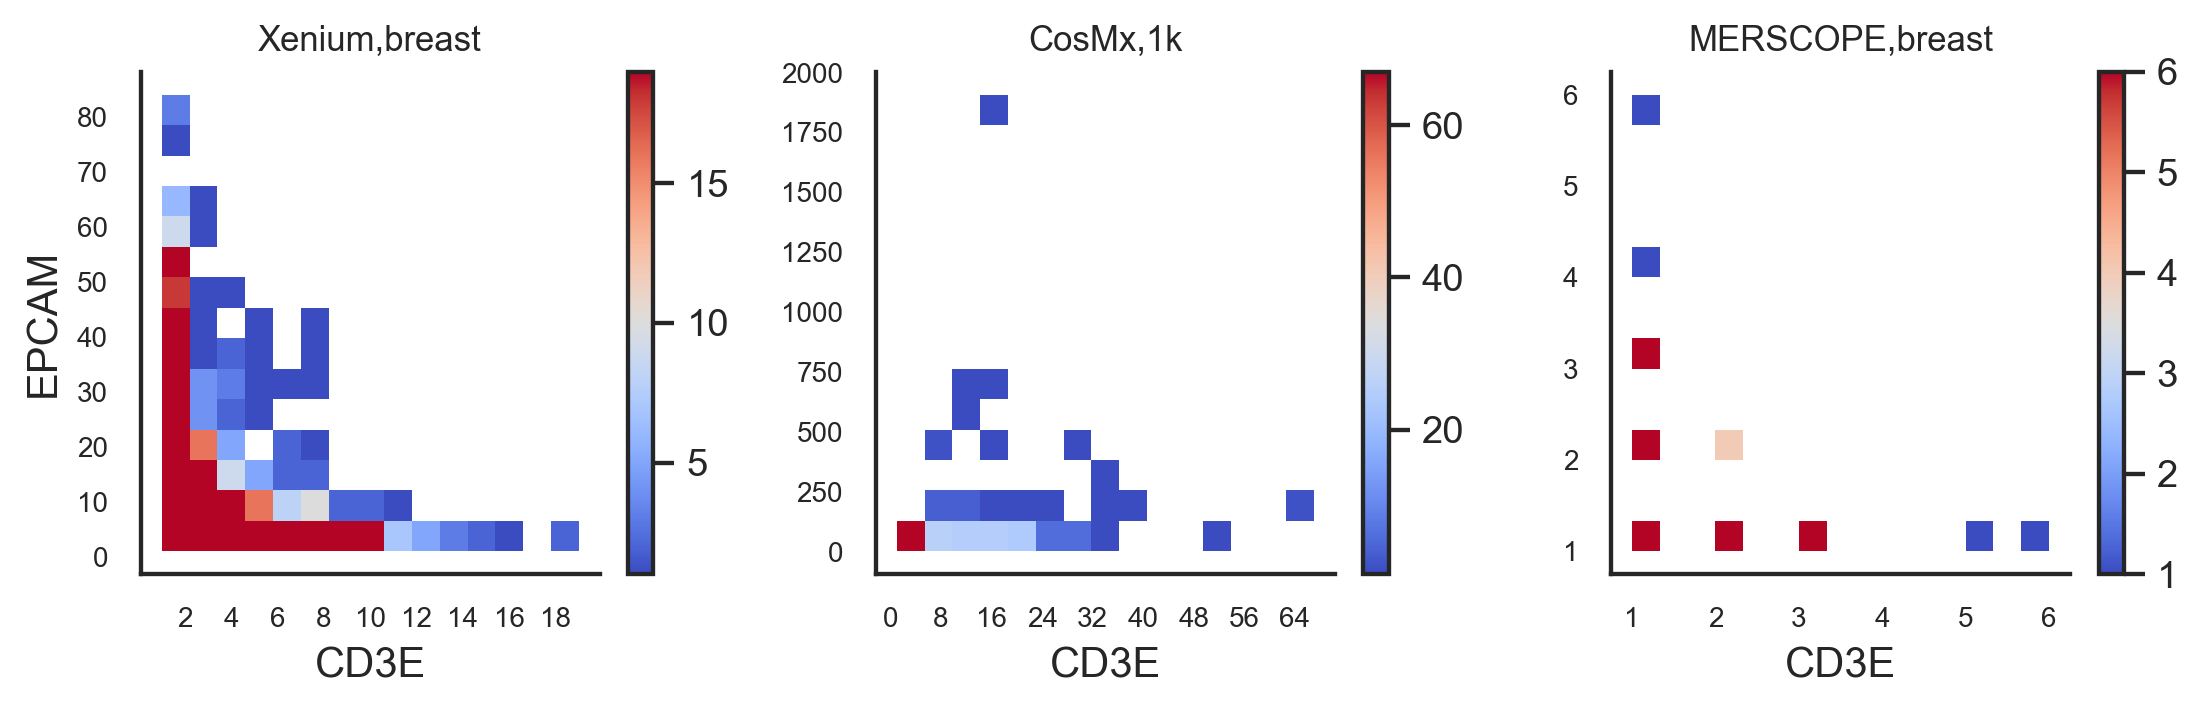

CD4 CD8A
2024_xenium_breast_htma
2024_cosmx_multitissue_htma
2024_merscope_breast_htma


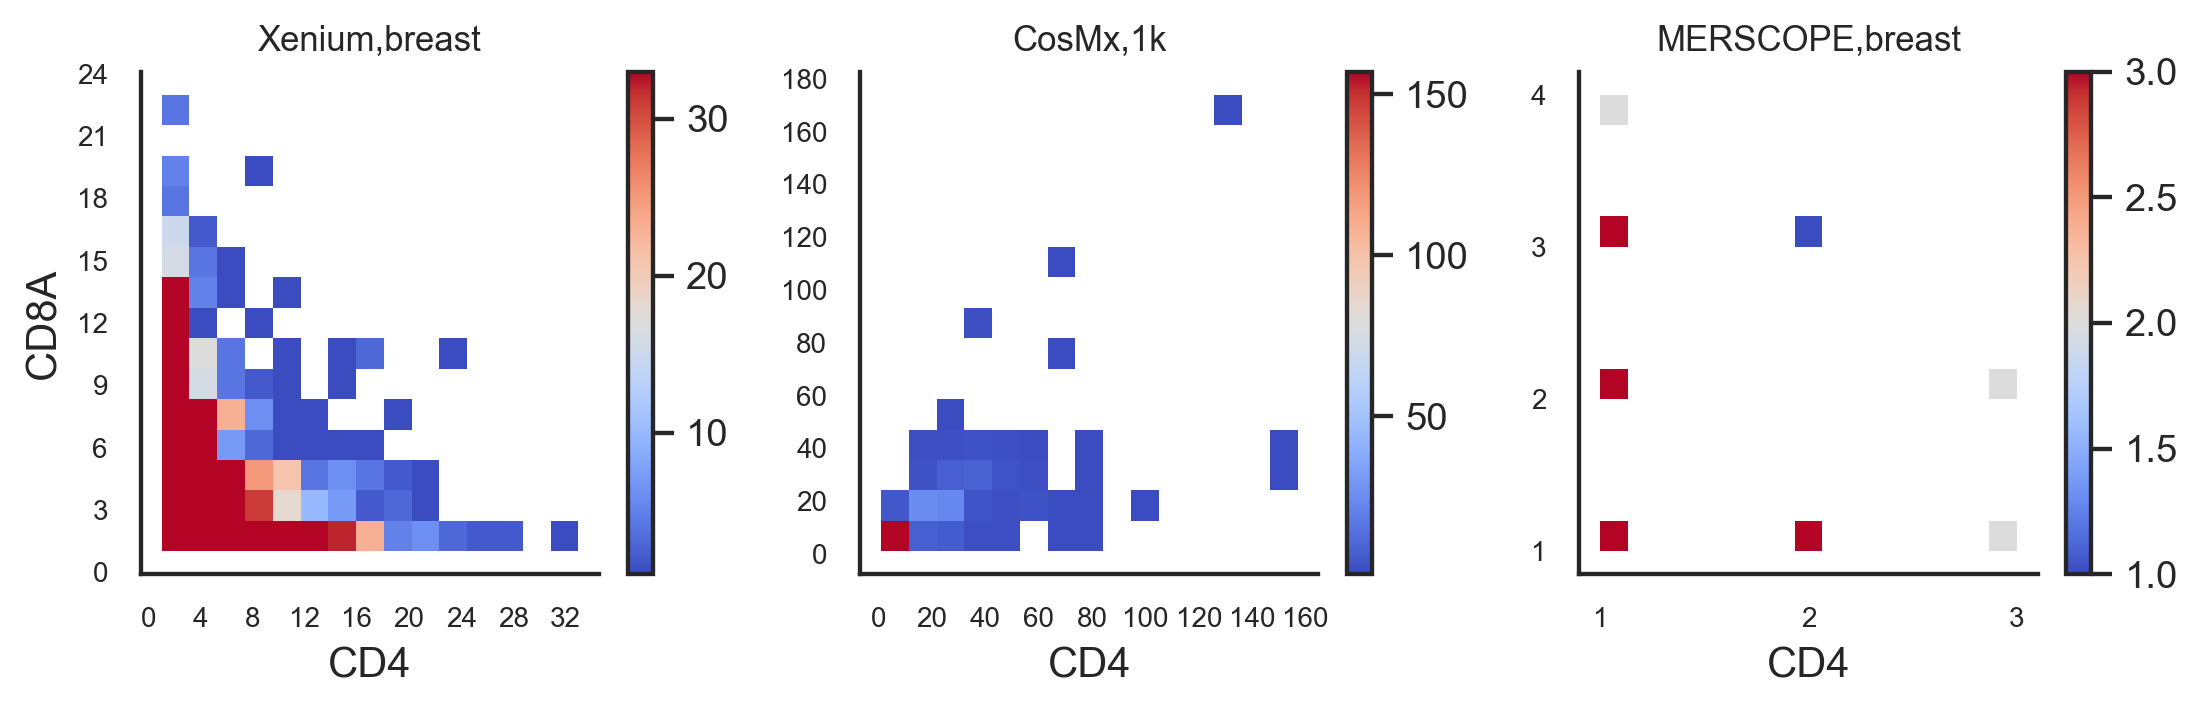

PPARG CD68
2024_xenium_breast_htma
2024_cosmx_multitissue_htma
2024_merscope_breast_htma


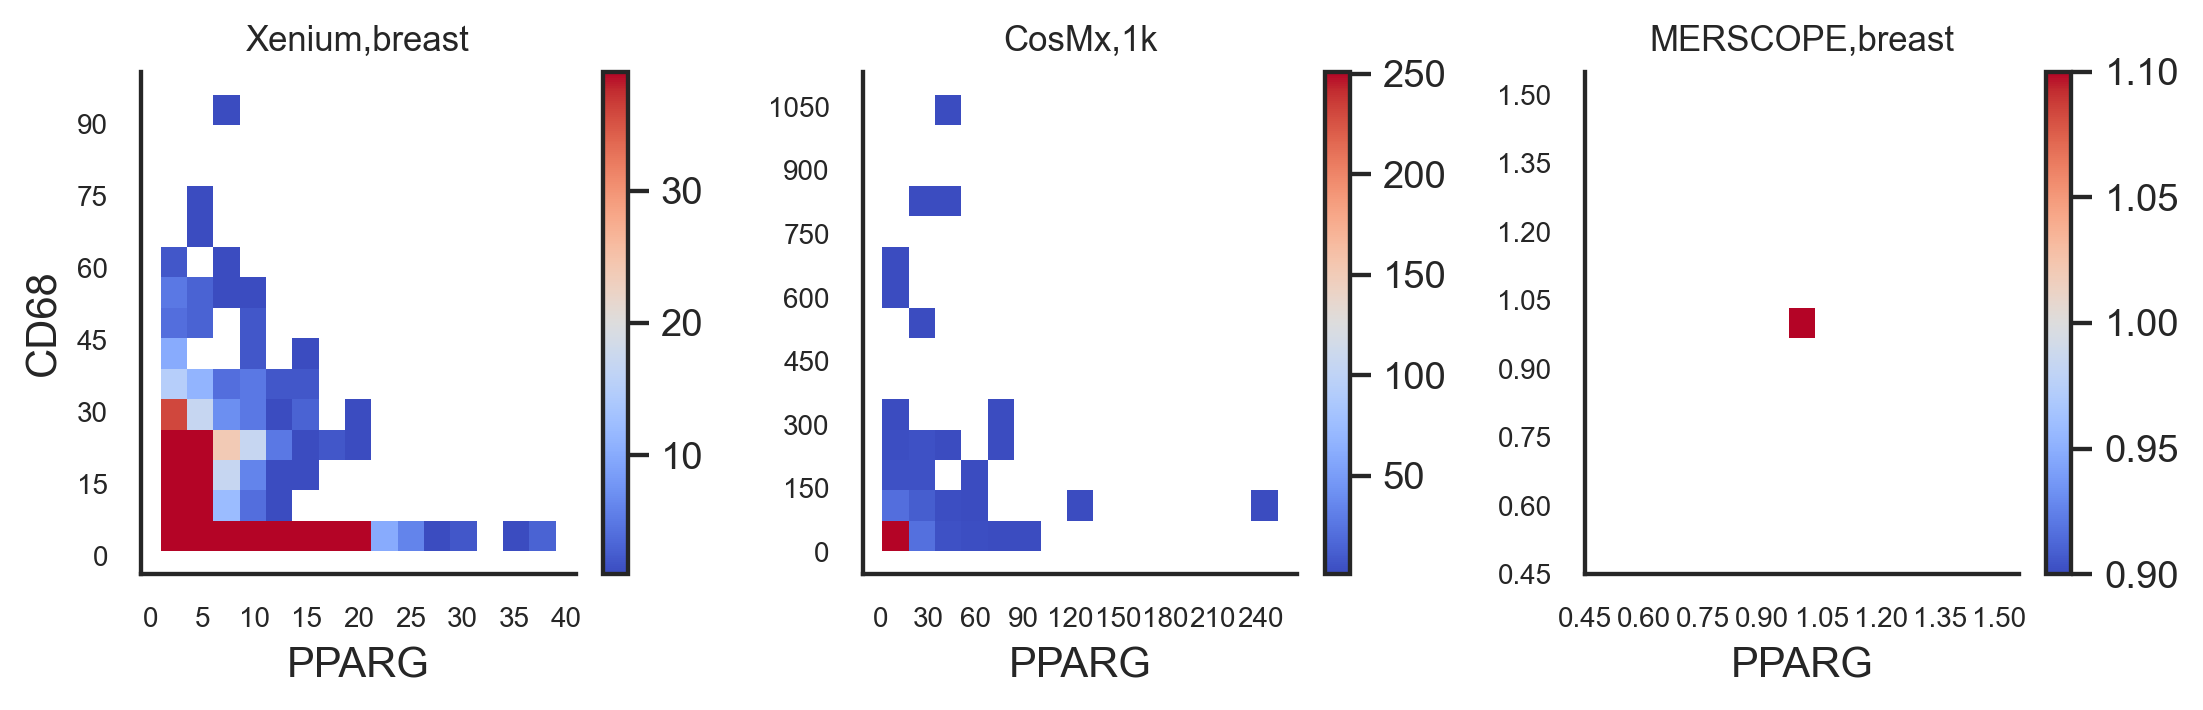

In [2]:

if not os.path.exists(f'{wd}/figures/coexpression'):
    os.makedirs(f'{wd}/figures/coexpression')

gene_1_list = ['CD3E','CD4','PPARG','CD3E','TACSTD2','ADIPOQ'][:3] # 'ADIPOQ', 'EGFR','KRT7'
gene_2_list = ['EPCAM','CD8A','CD68','CD19','FCER1G','CD14'][:3]  #'CD14','CD19','IL2RA'

for gene_1, gene_2 in zip(gene_1_list,gene_2_list):
    
    print (gene_1, gene_2)
    df_all = pd.DataFrame()
    for sample in samples:

        try:
            print (sample)
            # Convert relevant columns to numeric type
            df_cell_by_gene = pd.read_parquet((f'{wd}/data/cell_by_gene_csv/{sample}_cell_by_gene.parquet.gzip'))
            df_cell_by_gene = df_cell_by_gene.loc[~df_cell_by_gene['cell_id'].str.contains('-1_region')]
            

            df_plot = df_cell_by_gene[['core', 'tissue_type',gene_1,gene_2]]
            df_plot['core'] =  df_plot['core'].astype('int')

            # # Restrict to certain tissue types
            # df_plot = df_plot.loc[df_plot['tissue_type'].isin(['Spleen', 'Tonsil','Pancreas','Thyroid','LN','OV'])]

            df_plot['product'] = df_plot.apply(lambda row: row[gene_1]*row[gene_2], axis=1)
            df_plot = df_plot.loc[df_plot['product']>0]

            df_plot = df_plot.loc[df_plot[gene_1]>0]
            df_plot = df_plot.loc[df_plot[gene_2]>0]

            df_plot['sample'] = sample
            df_all = pd.concat([df_all, df_plot])
            df_all = df_all.loc[(df_all[f"{gene_1}"] !=0) & (df_all[f"{gene_2}"] !=0)]

        except:
            continue

    df_all['platform_panel'] = df_all['sample'].apply(lambda x: f"{name_parser(x)['platform']}_{name_parser(x)['panel']}")
    df_all = correct_platform_panel(df_all, 'platform_panel')        

    # Create a facet grid of heatmaps
    sns.set(style='white', rc={'figure.dpi': 250, 'axes.facecolor':(0,0,0,0), 'figure.facecolor':(0,0,0,0)})

    # Define the size and aspect ratio for the FacetGrid
    height_of_each_facet = 3  # example value, adjust as needed
    aspect_ratio_of_each_facet = 1  # example value, adjust as needed

    g = sns.FacetGrid(df_all, col="sample", sharex=False, sharey=False, 
                    margin_titles=True, despine=True, col_wrap=3, 
                    height=height_of_each_facet, aspect=aspect_ratio_of_each_facet,
                    gridspec_kws={"wspace": 0.01})

    g.map_dataframe(lambda data, **kwargs: sns.histplot(data=data, x=f"{gene_1}", y=f"{gene_2}", 
                                                        bins=15, cbar=True, cmap='coolwarm', 
                                                        vmin=1, vmax=data[gene_1].max(), **kwargs))
    g.set_axis_labels(f"{gene_1}", f"{gene_2}")

    # Add titles
    for platform_panel, ax in zip(df_all["platform_panel"].unique(), g.axes.flat):
        ax.set_facecolor('none')
        ax.set_title(f"{platform_panel}",fontsize=10)
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.tick_params(axis='both', which='major', labelsize=8)

    # Show the plot
    plt.tight_layout()

    plt.savefig(f'{wd}/figures/coexpression/Main_Fig_4_Coexpression_{gene_1}_vs_{gene_2}_{year}.png', bbox_inches='tight', transparent=True)
    plt.savefig(f'{wd}/figures/coexpression/Main_Fig_4_Coexpression_{gene_1}_vs_{gene_2}_{year}.eps', bbox_inches='tight', transparent=True)
    plt.show()

# Summed expression across matching cores

In [20]:
genes = list(set(gene_1_list+gene_2_list))

for sample_list in [['2024_xenium_breast_htma', '2024_merscope_breast_htma','2024_cosmx_multitissue_htma']]:

    print (sample_list)
    df_all = pd.DataFrame()
    for sample in sample_list:
        # Convert relevant columns to numeric type
        df_cell_by_gene = pd.read_parquet((f'data/cell_by_gene_csv/{sample}_cell_by_gene.parquet.gzip'))
        df_cell_by_gene = df_cell_by_gene.loc[~df_cell_by_gene['cell_id'].str.contains('-1_region')]
        df_plot = df_cell_by_gene[['core', 'tissue_type']+genes]
        df_plot['core'] =  df_plot['core'].astype('int')
        df_plot = df_plot.loc[df_plot['core'].isin(matching_cores)]
        df_plot['sample'] = sample
        df_all = pd.concat([df_all, df_plot])

    df_plot = df_all.groupby(by=['sample','tissue_type']).sum().reset_index()
    df_plot = df_plot.drop(columns = ['core'])
    df_plot = df_plot.melt(id_vars=['sample', 'tissue_type'], 
                value_vars=genes,
                var_name='gene', value_name='expression')

    fontsize=15
    width=900
    height=120*len(genes)

    # Define your initial figure
    fig = px.bar(df_plot, x="tissue_type", y="expression",
                color='sample', barmode="group", 
                facet_row="gene",
                width=width, height=height)

    # Update x-axis settings with black text
    fig.update_xaxes(tickvals=df_plot['tissue_type'].unique(), tickangle=270, title_text='', 
                    title_font=dict(color='black'), tickfont=dict(color='black', size=fontsize))

    # Update y-axis settings with black text
    fig.update_yaxes(matches=None, title_text='', title_font=dict(color='black'), tickfont=dict(color='black', size=fontsize-2))
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

    # Update legend settings
    fig.update_layout(
        legend=dict(
            orientation="h",  # horizontal alignment
            yanchor="bottom", 
            y=1,  # position legend just above the plot
            xanchor="right",
            x=0.99  # center the legend
        ),
        font=dict(color='black'),  # Set global font color to black
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        
    )

    # Modify row title annotations and set text color to black
    for annotation in fig.layout.annotations:
        annotation.font.size = fontsize
        annotation.font.color = 'black'  # Set the annotation text color to black
        annotation.x = -0.06
        annotation.textangle = 270
        for metric in df_plot.gene.unique():
            if annotation.text == f'gene={metric}':
                annotation.text = metric

    # Display the figure and save to file
    fig.show()
    pio.write_image(fig, f"{wd}/figures/coexpression/summed_expression_{'_'.join(sample_list)}.png",scale=4, width=width, height=height)
    pio.write_image(fig, f"{wd}/figures/coexpression/summed_expression_{'_'.join(sample_list)}.eps",scale=4, width=width, height=height)



['2024_xenium_breast_htma', '2024_merscope_breast_htma', '2024_cosmx_multitissue_htma']
